# Topic Model Research Notebook

The following notebook is designed to give a user a notebook environment to train lda models, view results, and further
optimize parameters based on the data being trained.

Users will be able to:
- Select Data from a given directory.
- Set parameters for LDA model to be trained.
- View coherence plots.
- View pyLDAvis of topics for entire corpora.
- View Topic Interpretability Table for entire corpora.
- Set parameter for recommender systems*
- View results of recommender system.
- View recommender system visuals.
- View brief description(s) on algorithms and parameters used for models.

[*] To be decided


In [7]:
# Import libraries
import os
from tkinter import *
from tkinter import filedialog
import ipywidgets as widgets
from IPython.display import display
import io
import pandas as pd
import json
from cleantext import *
from stopwordslist import *
import gensim
from gensim import corpora
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\donal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Set Up Data Directory

Locate the 'config.ini' file and set the directory for your files.

In [4]:
# Set directory where files can be accessed.
os.chdir('../../data/reviews')

In [5]:
# Display list of files in SelectMultiple format
files_to_use = widgets.SelectMultiple(
    options=os.listdir(),
    # value=['Files'],
    # rows=10
    description='Files',
    disabled=False
)

In [8]:
display(files_to_use)

SelectMultiple(description='Files', options=('meta_Prime_Pantry.json', 'meta_Prime_Pantry_Copy.json'), value=(…

In [9]:
files_to_use.value

('meta_Prime_Pantry.json',)

In [10]:
# Load Data
data = []
for line in open(files_to_use.value[0], 'r'):
    data.append(json.loads(line))


In [11]:
df = pd.DataFrame(data)

df.head()

,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",[https://images-na.ssl-images-amazon.com/image...,,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",[https://images-na.ssl-images-amazon.com/image...,,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO
2,[],,[A perfect Lentil soup starts with Goya Lentil...,,"Goya Dry Lentils, 16 oz","[B003SI144W, B000VDRKEK]",[https://images-na.ssl-images-amazon.com/image...,,Goya,[],[],"[B074MFVZG7, B079PTH69L, B000VDRKEK, B074M9T81...",{'ASIN: ': 'B0000DIF38'},"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIF38
3,[],,[Saran Premium Wrap is an extra tough yet easy...,,"Saran Premium Plastic Wrap, 100 Sq Ft","[B01MY5FHT6, B000PYF8VM, B000SRMDFA, B07CX6LN8...",[https://images-na.ssl-images-amazon.com/image...,,Saran,[],[],"[B077QLSLRQ, B00JPKW1RQ, B000FE2IK6, B00XUJHJ9...",{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIWNI
4,[],,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...,,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",[],[https://images-na.ssl-images-amazon.com/image...,,Saran,[],[],[B0014CZ0TE],{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIWNZ


In [12]:
# Extract only review text and sample 1000
reviews = pd.DataFrame(df.description).sample(5000)
reviews = reviews.applymap(lambda x: x if not isinstance(x, list) else x[0] if len(x) else '')

In [13]:
# Set directory where files can be accessed.
os.chdir('../../topicmodel')

In [14]:
# Clean reviews
clean_reviews = clean_all(reviews, 'description')

clean_reviews.head()

,description
6963,b keep your style fresh without the hassle of ...
4794,b sometimes you ve get to pull out the big gun...
1906,b wild planet be commit to provide the fine ta...
3866,b covergirl clump crusher water resistant masc...
4145,b campbells condense healthy request bean with...


## Form Bigrams and Trigrams

### Compute PMI Scores

In [15]:
def compute_bigram_pmi(word_frequency=50):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split()
                                                                   for comment in clean_reviews.description])
    # Filter only those that occur at least 50 times
    finder.apply_freq_filter(word_frequency)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)
    
    # Calculate pmi scores
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

    return bigram_pmi

def compute_trigram_pmi(word_frequency=50):
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split()
                                                                    for comment in clean_reviews.description])
    # Filter only those that occur at least 50 times
    finder.apply_freq_filter(word_frequency)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)
    
    # Calculate pmi scores
    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    
    return trigram_pmi

In [16]:
# Compute pmi scores
bigram_pmi = compute_bigram_pmi()

trigram_pmi = compute_trigram_pmi()

In [17]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True


In [18]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

### Set PMI Threshold Value

In [19]:
# PMI threshold can be set to any value which makes sense - eyeball through and select threshold where n-grams stop
# making sense. Choose top 500 ngrams, in this case, ranked by PMI that have noun like structures.
def set_bigram_pmi_threshold(pmi_threshold=5):
    filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                                  bigram_filter(bigram['bigram'])\
                                                  and bigram.pmi > pmi_threshold, axis = 1)][:500]
    bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]

    return bigrams

def set_trigram_pmi_threshold(pmi_threshold=5):
    filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > pmi_threshold, axis = 1)][:500]


    trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

    return trigrams

In [20]:
bigrams = set_bigram_pmi_threshold()

trigrams = set_trigram_pmi_threshold()

In [21]:
# Bigram Sample
bigrams[:10]

['duncan hine',
 'united state',
 'project verify',
 'drug administration',
 'individually wrap',
 'fructose corn',
 'gmo project',
 'fatty acid',
 'amino acid',
 'sea salt']

In [22]:
# Trigram Sample
trigrams[:10]

['gmo project verify',
 'fructose corn syrup',
 'diagnose treat cure',
 'non gmo project',
 'high fructose corn',
 'wellness complete health',
 'dry cat food',
 'dry dog food',
 'food grain free']

In [23]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

### Output Comments W NGrams

In [24]:
def output_comments_w_ngrams():
    
    comments_w_ngrams = clean_reviews.copy()
    
    comments_w_ngrams.description = comments_w_ngrams.description.map(lambda x: replace_ngram(x))
    
    # Tokenize comments + remove stop words + remove words with less than 2 characters
    comments_w_ngrams = comments_w_ngrams.description.map(lambda x: [word for word in x.split()\
                                                                     if word not in stop_word_list\
                                                                     and word not in english_names\
                                                                     and len(word) > 2])
    return comments_w_ngrams

In [25]:
comments_w_ngrams = output_comments_w_ngrams()

In [26]:
comments_w_ngrams.head()

6963    [style, fresh, hassle, cleanup, remington, vac...
4794    [pull, big, gun, seventh, generation, ultra, p...
1906    [wild, planet, commit, provide, fine, tasting,...
3866    [covergirl, clump, crusher, water, resistant, ...
4145    [campbells, condense, healthy, request, bean, ...
Name: description, dtype: object

## Filter for only nouns

Filtering for nouns cleans the text for words that are more interpretable in the topic model.

In [27]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_comments = comments_w_ngrams.map(noun_only)

# LDA Model

In [56]:
## Optimize for k topics

To improve human interpretability, let's focus on the enchancement of the Cv measures as indicated
[here](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). This measure assess the interpretability of
topics given the set of words in the generated topics.

If the same words start appearing across multiple topics, the number of topics is too high.


LDA Training - Number of Topics: 5
LDA Training - Number of Topics: 6
LDA Training - Number of Topics: 7
LDA Training - Number of Topics: 8
LDA Training - Number of Topics: 9
LDA Training - Number of Topics: 10
LDA Training - Number of Topics: 11
LDA Training - Number of Topics: 12
LDA Training - Number of Topics: 13
LDA Training - Number of Topics: 14
LDA Training - Number of Topics: 15
LDA Training - Number of Topics: 16
LDA Training - Number of Topics: 17
LDA Training - Number of Topics: 18
LDA Training - Number of Topics: 19
LDA Training - Number of Topics: 20
LDA Training - Number of Topics: 21
LDA Training - Number of Topics: 22
LDA Training - Number of Topics: 23
LDA Training - Number of Topics: 24
LDA Training - Number of Topics: 25


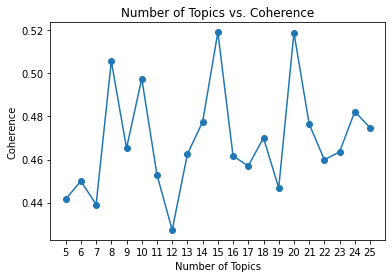

In [57]:
def output_coherence_model(final_comments, starting_topic_num, ending_topic_num,
                     lda_passes, lda_iterations, lda_chunksize):
    # Initialize corpora dictionary of comments
    comment_dictionary = corpora.Dictionary(final_comments)
    
    # Initialize document-term-matrix
    doc_term_matrix = [comment_dictionary.doc2bow(doc) for doc in final_comments]
    
    # Optimize for k topics
    # Initialize cohere value list
    coherence = []
    # Obtainn Coherence Models by training multiple LDA models with different topic values and parameters. 
    for k in range(starting_topic_num, ending_topic_num):
        print('LDA Training - Number of Topics: ' + str(k))
        lda = gensim.models.ldamodel.LdaModel
        lda_model = lda(doc_term_matrix, num_topics=k, id2word=comment_dictionary, passes=lda_passes,
                       iterations=lda_iterations, chunksize=lda_chunksize, eval_every=None)
        
        coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=final_comments,
                                                        dictionary=comment_dictionary, coherence='c_v')
        
        coherence.append((k, coherence_model.get_coherence()))
    
    # Intialize x and y values for coherenence model evaluations
    x_val = [x[0] for x in coherence]
    y_val = [x[1] for x in coherence]
    
    # Plot coherence model results to determine the best number of topics using 
    # the given parameters. 
    plt.plot(x_val,y_val)
    plt.scatter(x_val,y_val)
    plt.title('Number of Topics vs. Coherence')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence')
    plt.xticks(x_val)
    plt.show()
    
    return comment_dictionary, doc_term_matrix

comment_dict, full_dtm = output_coherence_model(final_comments, 5, 26, 40, 200, 1000)

In [58]:
## Output Best LDA Model(s)

In [59]:
def output_best_lda_model(full_dtm, best_num_topics, num_words_per_topic, comment_dictionary, best_num_lda_passes,
                          best_num_lda_iterations, best_num_lda_chunksize, random_state_value=0):
    Lda = gensim.models.ldamodel.LdaModel
    lda_model = Lda(full_dtm, num_topics=best_num_topics, id2word = comment_dictionary, passes=best_num_lda_passes,\
                   iterations=best_num_lda_iterations,  chunksize = best_num_lda_chunksize, eval_every = None, random_state=random_state_value)
    
    lda_model.show_topics(best_num_topics, num_words=num_words_per_topic, formatted=False)
    
    return lda_model

best_lda_model = output_best_lda_model(full_dtm, 11, 10, comment_dict, 40, 200, 1000)

In [63]:
## Relevancy - Topic Modeling Visualiztion

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_data =  pyLDAvis.gensim.prepare(best_lda_model, full_dtm, comment_dict, mds = 'pcoa')
pyLDAvis.display(topic_data)

In [66]:
## Extract Word List for each Topic Using a Predefined Lambda

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
def output_word_list(_lambda):
    # To extract words for a given lambda.
    all_topics = {}
    num_terms = 10 # Adjust number of words to represent each topic
    # _lambda = 0.08 # Adjust this accordingly based on tuning above
    for i in range(1,9): #Adjust this to reflect number of topics chosen for final LDA model
        topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
        topic['relevance'] = topic['loglift']*(1-_lambda)+topic['logprob']*_lambda
        all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

    topics_df = pd.DataFrame(all_topics).T
    return topics_df

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
Topic 1,hair,skin,conditioner,shampoo,lip,shine,lotion,makeup,moisturizer,damage
Topic 2,snack,chocolate,bar,chip,crunch,peanut_butter,cheddar,dip,potato_chip,iced_tea
Topic 3,calcium,fever,intend,statement,vitamin_d,supplement,diagnose_treat_cure,magnesium,hershey,brain
Topic 4,boiron,knorr,commit,tender,peppermint,stomach,battery,cavity,crocker,bathroom
Topic 5,coffee,eye,lash,curl,toothpaste,mascara,chili,foot,dandruff,shoulder
Topic 6,detergent,relief,sheet,ache,symptom,cough,throat,pain,laundry,headache
Topic 7,dog,cat,cat_food,dog_food,wellness,bandage,wellness_complete_health,gum,dry_cat_food,grain_free
Topic 8,cereal,almond,breakfast,grain,barilla,quaker,granola,oat,bread,chunk


output_word_list(.08)

In [69]:
## Inspecting Topics

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
def inspect_topics(lda_model):
    for topic_id in range(lda_model.num_topics):
        topk = lda_model.show_topic(topic_id, 8)
        topk_words = [ w for w, _ in topk ]

        print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: rice family product food ingredient soup year company
1: coffee eye use product cup water bean chili
2: grain food cereal almond wheat breakfast pasta help
3: protein food product health help support calcium body
4: relief pain use product stain symptom detergent water
5: protection design help comfort support size pad fit
6: dog cat cat_food health food ingredient dog_food wellness
7: cracker heat beef style stick work thing feature
8: flavor snack taste bar fruit chocolate pack chip
9: tea day image protection odor mint body_wash deodorant
10: hair skin use help oil formula conditioner color


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


inspect_topics(best_lda_model)

In [73]:
# Predict the topics of a Document

Results here will continuously vary due to random number generation of the algorithm.
This method can be used a means to determine how well a topic relates to a comment.


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
# Example
def predict_topics(document, lda_model):
    doc = document.split()

    doc_vector = lda_model.id2word.doc2bow(doc)
    doc_topics = lda_model[doc_vector]
    
    print(doc_topics)

[(0, 0.03031991), (1, 0.03031991), (2, 0.3635675), (3, 0.03031991), (4, 0.03031991), (5, 0.03031991), (6, 0.03031991), (7, 0.03031991), (8, 0.03031991), (9, 0.36355335), (10, 0.03031991)]


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


predict_topics('this book describes windows software', best_lda_model)

In [ ]:
# Recommending a topic based on word association weights.

A recommender system could be used to potentially determine the exact predefined topic for a word.

In [ ]:
### Train Multiple Coherence Models with a list of numerous parameters

In [ ]:
# Set Dictionary with list of various parameter values
lda_training_dictionary = {'lda_passes' : [],
                          'lda_iterations': [],
                          'lda_chunksize': []}

In [ ]:
#### User Interface - Coherence Model Training

# Topic Model Optimization: Grid Search

## Algorithms and Parameters: A Brief Description

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import gensim


# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\cupy\_environment.py:205: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\cupy\_environment.py:205: UserWa

## Import Newsgroups Text Data

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


In [3]:
df.head(15)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
5,From: dfo@vttoulu.tko.vtt.fi (Foxvog Douglas)\...,16,talk.politics.guns
6,From: bmdelane@quads.uchicago.edu (brian manni...,13,sci.med
7,From: bgrubb@dante.nmsu.edu (GRUBB)\nSubject: ...,3,comp.sys.ibm.pc.hardware
8,From: holmes7000@iscsvax.uni.edu\nSubject: WIn...,2,comp.os.ms-windows.misc
9,From: kerr@ux1.cso.uiuc.edu (Stan Kerr)\nSubje...,4,comp.sys.mac.hardware


## Remove emails and newline characters

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-4-10af9153bd18>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-4-10af9153bd18>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


## Tokenize and Clean-up using gensim’s simple_preprocess()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## Lemmatization

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['where s thing subject car be nntp post host rac wam umd organization university maryland college park line be wonder out there enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know tellme model name engine spec year production where car be make history info have funky look car mail thank bring neighborhood lerxst', 'guy kuo subject si clock poll final call summary final call si clock report keyword acceleration clock upgrade article shelley qvfo innc organization university washington line nntp post host carson edu fair number brave soul upgrade si clock oscillator have share experience poll send brief message detail experience procedure top speed attain cpu rate speed add card adapter heat sink hour usage day floppy disk functionality floppy be especially request be summarize next day so add network knowledge base have do clock upgrade have answer poll thank guy kuo']


## Create the Document-Word matrix

In [10]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Check the Sparsicity

In [11]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsicity:  0.774718191739816 %


##  Build LDA model with sklearn

In [13]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [14]:
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)

## Diagnose model performance with perplexity and log-likelihood

In [15]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -9931933.236713089
Perplexity:  2030.1262365489392
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


## How to GridSearch the best LDA model?

In [16]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

## How to see the best topic model and its parameters?

In [17]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -2098464.4290610477
Model Perplexity:  1951.2587473765655


## Compare LDA Model Performance Scores

In [73]:
for key, value in model.cv_results_.items():
    if key == 'params_learning_decay':
        print(key, value)
    
for dvalue, mscore in zip(model.cv_results_['param_learning_decay'], model.cv_results_['mean_test_score']):
    if dvalue == 0.5:
        print(round(mscore))

-2098464
-2122452
-2142434
-2166010
-2186241


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


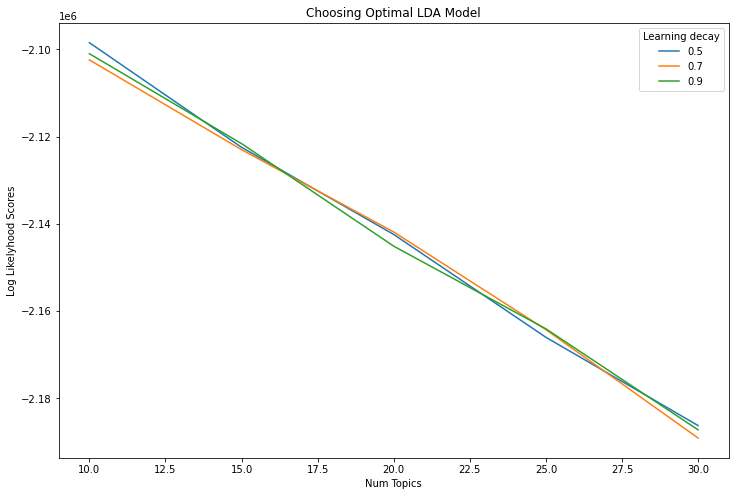

In [74]:
# Store learning decay and mean test scores, respectively


# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(mscore) for dvalue, mscore in zip(model.cv_results_['param_learning_decay'], model.cv_results_['mean_test_score']) if dvalue==0.5]
log_likelyhoods_7 = [round(mscore) for dvalue, mscore in zip(model.cv_results_['param_learning_decay'], model.cv_results_['mean_test_score']) if dvalue==0.7]
log_likelyhoods_9 = [round(mscore) for dvalue, mscore in zip(model.cv_results_['param_learning_decay'], model.cv_results_['mean_test_score']) if dvalue==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## How to see the dominant topic in each document?

In [76]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980000,0.000000,0.000000,7
Doc1,0.000000,0.000000,0.090000,0.610000,0.000000,0.030000,0.090000,0.000000,0.000000,0.170000,3
Doc2,0.000000,0.000000,0.000000,0.420000,0.140000,0.000000,0.080000,0.140000,0.000000,0.220000,3
Doc3,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.150000,0.000000,0.000000,0.230000,3
Doc4,0.000000,0.000000,0.220000,0.130000,0.170000,0.240000,0.000000,0.240000,0.000000,0.000000,5
Doc5,0.340000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.450000,0.000000,0.000000,7
Doc6,0.000000,0.000000,0.000000,0.360000,0.000000,0.220000,0.170000,0.120000,0.110000,0.000000,3
Doc7,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
Doc8,0.000000,0.000000,0.000000,0.000000,0.000000,0.720000,0.000000,0.000000,0.000000,0.240000,5
Doc9,0.000000,0.000000,0.000000,0.560000,0.000000,0.270000,0.160000,0.000000,0.000000,0.000000,3


## Add Comment ID's and predetermined topics to table

## Review topics distribution across documents

In [77]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic Num,Num Documents
0,9,1783
1,3,1647
2,4,1602
3,7,1582
4,6,1295
5,5,1179
6,0,874
7,2,631
8,8,366
9,1,355


## How to visualize the LDA model with pyLDAvis?

In [78]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4      32.420952   8.115230       1        1  18.532982
0       0.648955  71.707100       2        1  12.117210
5      71.019684   9.971006       3        1  11.717984
7       3.785981  33.185135       4        1  10.820860
6     -42.666500  -9.222070       5        1  10.247146
9      -3.621689 -43.526516       6        1   9.528044
3      -3.632402  -4.171708       7        1   9.318958
2     -36.584400  35.804413       8        1   7.335847
1      44.391380  50.615383       9        1   6.820493
8      40.235809 -31.591665      10        1   3.560476, topic_info=        Term         Freq         Total Category  logprob  loglift
5352     max  4315.000000   4315.000000  Default  30.0000  30.0000
3282    file  3102.000000   3102.000000  Default  29.0000  29.0000
9563  window  3055.000000   3055.000000  Default  28.0000  28.0000
3674     god  2551.000000   2551.000000  Default  27.0000  27.0000
8143   space  1866.000000   1866.000000  Default  26.0000  26.0000
...      ...          ...           ...      ...      ...      ...
9651   write   240.763913  10029.881708  Topic10  -5.2619  -0.3942
4814    know   202.520757   6530.879387  Topic10  -5.4349  -0.1382
9702    year   181.545306   3945.910153  Topic10  -5.5443   0.2563
8819    time   182.245271   5061.818448  Topic10  -5.5404   0.0111
6443  people   175.668381   5973.297784  Topic10  -5.5772  -0.1912

[803 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
20        1  0.916599  absolute
20        2  0.020991  absolute
20        3  0.006997  absolute
20        4  0.006997  absolute
20        5  0.020991  absolute
...     ...       ...       ...
9704     10  0.990717     yeast
9729      6  0.963363      zeos
9736      1  0.014292   zionism
9736      4  0.986114   zionism
9741      8  0.988676   zoology

[2351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 8, 7, 10, 4, 3, 2, 9])

## How to see the Topic’s keywords?

In [79]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,aaa,aaron,abandon,abbreviation,abc,aberystwyth,abide,ability,able,abolish,...,zion,zionism,zionist,zip,zisfein,zone,zoology,zoom,zubov,zurich
Topic0,0.100006,0.100031,0.100025,0.100004,0.840453,0.100000,56.055510,79.604288,140.942845,30.684694,...,0.100013,0.100008,0.100013,14.724914,30.685198,5.876553,0.100002,3.168771,0.100000,0.100068
Topic1,0.100000,0.100011,11.712593,0.100000,2.874939,0.100001,0.256817,5.946867,45.083892,0.100028,...,0.100020,0.100134,74.498271,0.100005,0.100000,31.723425,0.100000,0.100000,0.100004,0.100000
Topic2,0.100002,0.100022,2.100750,1.644252,0.100031,0.100004,0.100000,3.771547,56.763840,0.100003,...,0.100001,0.100000,0.100000,2.126454,0.100000,0.100014,83.099980,0.100013,0.100015,0.501372
Topic3,0.100003,10.379548,0.100007,0.100009,0.100002,0.100034,0.100001,20.516228,175.622980,0.100000,...,0.100000,0.100000,0.100000,5.106141,0.100001,11.876459,0.100005,6.103634,0.100000,14.698475
Topic4,0.100006,17.069175,34.258494,0.100004,0.100012,0.100007,4.664245,90.993584,183.837903,27.515255,...,3.824734,0.526643,2.013278,0.100013,0.100003,0.100007,0.100001,0.100005,0.100000,0.100001


## Get the top 15 keywords each topic

In [80]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,key,use,government,law,people,state,make,right,chip,encryption,public,say,clipper,president,know
Topic 1,armenian,turkish,people,war,say,kill,jew,arab,israel,world,year,government,turk,turkey,greek
Topic 2,space,nasa,line,organization,subject,science,center,research,launch,year,university,use,earth,program,orbit
Topic 3,line,drive,use,subject,organization,card,problem,write,disk,scsi,window,post,work,know,driver
Topic 4,say,people,god,write,think,know,make,subject,christian,line,believe,just,organization,come,thing
Topic 5,file,use,window,line,program,subject,image,organization,write,version,run,server,available,display,ftp
Topic 6,game,line,team,subject,organization,year,write,play,good,win,article,player,think,post,university
Topic 7,write,article,line,subject,organization,post,car,nntp,host,just,university,gun,think,make,say
Topic 8,max,food,disease,gordon,medical,bank,msg,doctor,subject,health,bhj,giz,patient,article,organization
Topic 9,line,subject,organization,post,university,host,nntp,new,good,sale,distribution,use,bike,article,write


## How to predict the topics for a new piece of text?

In [81]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['say', 'people', 'god', 'write', 'think', 'know', 'make', 'subject', 'christian', 'line', 'believe', 'just', 'organization', 'come', 'thing']


## How to cluster documents that share similar topics and plot?

In [82]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Component's weights: 
 [[ 0.14  0.07  0.13  0.43  0.45  0.25  0.31  0.38  0.05  0.51]
 [ 0.05  0.05 -0.   -0.55  0.76 -0.19  0.01  0.13  0.02 -0.24]]
Perc of Variance Explained: 
 [0.02 0.2 ]


c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Segregation of Topic Clusters')

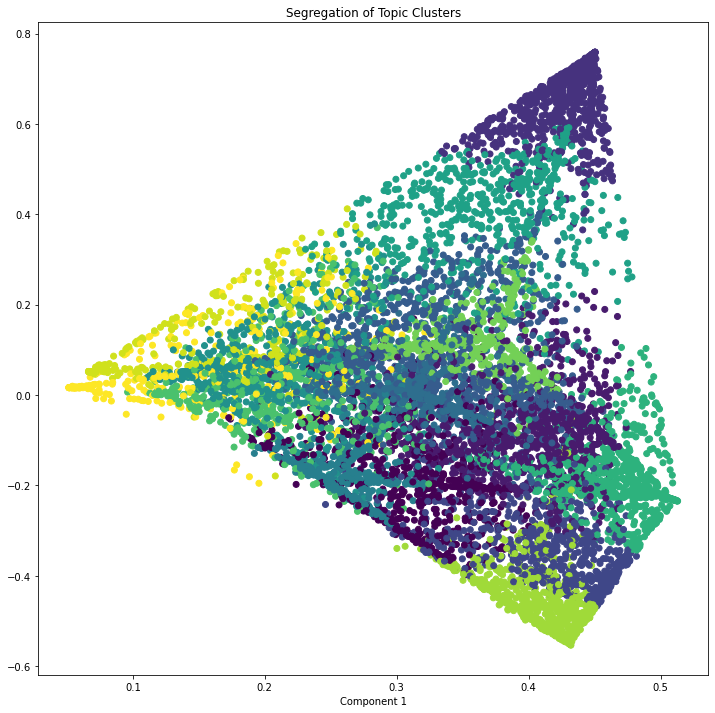

In [83]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

## How to get similar documents for any given piece of text?

In [84]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

c:\users\donal\anaconda3\envs\topic-modeling-optimization\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic KeyWords:  ['say', 'people', 'god', 'write', 'think', 'know', 'make', 'subject', 'christian', 'line', 'believe', 'just', 'organization', 'come', 'thing']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.8 0.  0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.8 0.  0.  0.  0.1 0.1]]

 From: Nanci Ann Miller Subject: Re: Concerning Gods Morality (long) Organization: Sponsored account, School of Computer Science, Carnegie Mellon, Pittsburgh, PA Lines: 56 NNTP-Posting-Host: po5.andrew.cmu.edu In-Reply-To: writes: > > Sorry, but there are no supernatural > > forces necessary to create a pathogen. You are saying, "Since > > diseases are bad, the bad entity must have created it." So > > what would you say about acid rain, meteors falling from the > > sky, volcanoes, earthquakes, an


- Apply Plotly.
    - Apply 3D plots
- Display Results
- Display predicted topics. 
- Map the predicted words to predetermined topics. 
    - What collection of words are seen for each pre-determined topic?
- Add description of algorithms and parameters. 
- Migrate to hub
- Apply predetermined number of topics. 
- Apply stopwords.
- Apply sentiment analysis